<a href="https://colab.research.google.com/github/tharushaliyanagama/OralCancerEarlyDetection-DSGP/blob/Prediction-of-textual-data-I/Text_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Dataset Analysis***

**1. Import Libraries**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import pickle

**2. Load and Inspect the Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/DSGP/DatasetNewII.csv')

In [ ]:
#Display information
print("Dataset Info:")
print(data.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   public_id             2237 non-null   int64  
 1   lesion_id             2237 non-null   int64  
 2   patient_id            2237 non-null   int64  
 3   localization          2237 non-null   object 
 4   larger_size           2237 non-null   float64
 5   tobacco_use           2237 non-null   object 
 6   alcohol_consumption   2237 non-null   object 
 7   sun_exposure          2237 non-null   object 
 8   gender                2237 non-null   object 
 9   skin_color            2237 non-null   object 
 10  age                   2237 non-null   int64  
 11  cancer_or_non_cancer  2237 non-null   object 
dtypes: float64(1), int64(4), object(7)
memory usage: 209.8+ KB
None


In [ ]:
#Load 5 rows
print("\nFirst 5 rows:")
print(data.head())


First 5 rows:
   public_id  lesion_id  patient_id localization  larger_size tobacco_use  \
0          0         50          48       Tongue          2.0         Yes   
1          1         50          48       Tongue          2.0         Yes   
2          2         41          39       Tongue          2.5         Yes   
3          3         41          39       Tongue          2.5         Yes   
4          4         87          81          Lip          1.5      Former   

  alcohol_consumption sun_exposure gender skin_color  age cancer_or_non_cancer  
0                  No           No      M      Black   76               Cancer  
1                  No           No      M      Black   86               Cancer  
2              Former          Yes      M      White   36               Cancer  
3              Former          Yes      M      White   32               Cancer  
4                 Yes          Yes      F      White   31               Cancer  


**3. Understand Numerical Features**

In [ ]:
# Remove unnecessary features based on correlation and domain knowledge
columns_to_drop = ['patient_id', 'public_id', 'lesion_id']  # Irrelevant for prediction
print(f"\nDropping columns: {columns_to_drop}")
data = data.drop(columns=columns_to_drop)


Dropping columns: ['patient_id', 'public_id', 'lesion_id']


In [ ]:
# Select numeric variables
numeric_columns = data.select_dtypes(include=['int64', 'float64'])

# Print numeric variables
print("Numeric Variables:")
print(numeric_columns.head())

Numeric Variables:
   larger_size  age
0          2.0   76
1          2.0   86
2          2.5   36
3          2.5   32
4          1.5   31


**4. Histograms for Numerical Features**

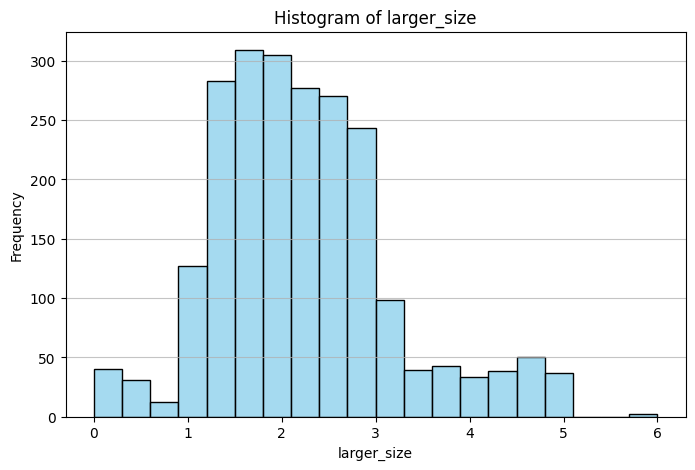

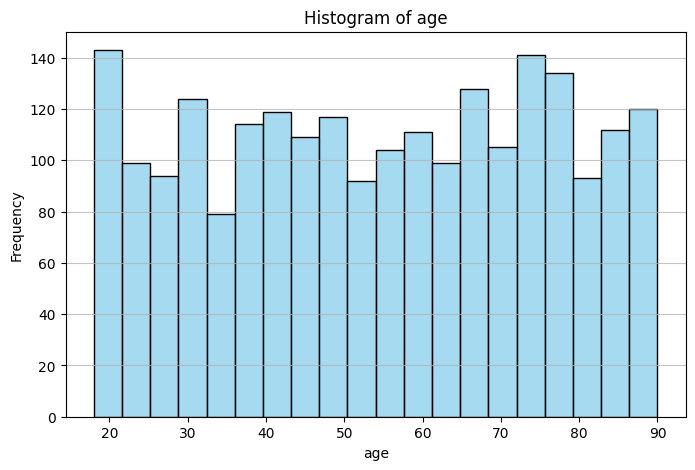

In [ ]:
# Plot histograms for specific numerical variables
for column in ['larger_size', 'age']:
    if column in data.select_dtypes(include=['number']).columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(data, x=column, bins=20, color='skyblue', edgecolor='black')
        plt.title(f"Histogram of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.grid(axis='y', alpha=0.75)
        plt.show()


**5. Box Plot to Identify Outliers**

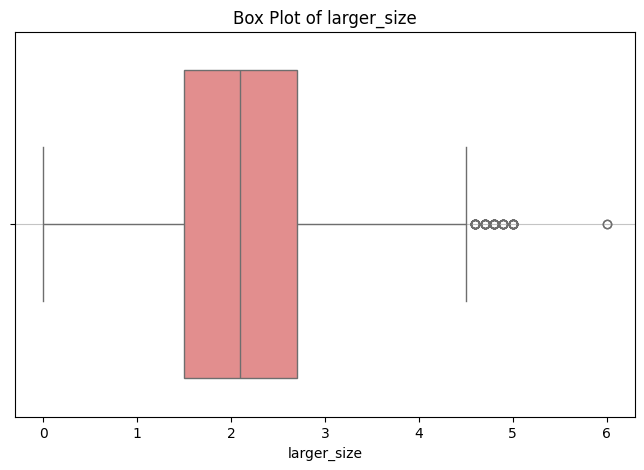

In [ ]:
# Plot box plots for specific numerical variables to identify outliers
for column in ['larger_size', 'age_group']:
    if column in data.select_dtypes(include=['number']).columns:
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=data, x=column, color='lightcoral')
        plt.title(f"Box Plot of {column}")
        plt.xlabel(column)
        plt.grid(axis='y', alpha=0.75)
        plt.show()

**6. Handle Outliers using IQR method**

In [ ]:
# Calculate the IQR for the 'larger_size' column
Q1 = data['larger_size'].quantile(0.25)  # 25th percentile
Q3 = data['larger_size'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the data to exclude outliers
filtered_data = data[(data['larger_size'] >= lower_bound) & (data['larger_size'] <= upper_bound)]

# Display the number of rows removed
removed_rows = len(data) - len(filtered_data)
print(f"Outliers removed: {len(data)} remaining rows")
print(f"Number of rows removed: {removed_rows}")

Outliers removed: 2237 remaining rows
Number of rows removed: 67


**7. Understand Categorical Features**

In [ ]:
# Select categorical variables
categorical_columns = data.select_dtypes(include=['object'])

# Print categorical variables
print("Categorical Variables:")
print(categorical_columns.head())

Categorical Variables:
  localization tobacco_use alcohol_consumption sun_exposure gender skin_color  \
0       Tongue         Yes                  No           No      M      Black   
1       Tongue         Yes                  No           No      M      Black   
2       Tongue         Yes              Former          Yes      M      White   
3       Tongue         Yes              Former          Yes      M      White   
4          Lip      Former                 Yes          Yes      F      White   

  cancer_or_non_cancer  
0               Cancer  
1               Cancer  
2               Cancer  
3               Cancer  
4               Cancer  


**8. Unique values of each column**

In [ ]:
# Print unique values for each categorical column
print("\nUnique Values in Each Categorical Column:")
for column in categorical_columns.columns:
    unique_values = categorical_columns[column].unique()
    print(f"Column: {column}")
    print(f"Unique Values: {unique_values}")
    print("----")


Unique Values in Each Categorical Column:
Column: localization
Unique Values: ['Tongue' 'Lip' 'Floor of mouth' 'Buccal mucosa' 'Palate' 'Gingiva'
 'Cheek' 'Gum' 'Buccal Mucosa']
----
Column: tobacco_use
Unique Values: ['Yes' 'Former' 'No' 'Not informed']
----
Column: alcohol_consumption
Unique Values: ['No' 'Former' 'Yes' 'Not informed']
----
Column: sun_exposure
Unique Values: ['No' 'Yes' 'Not informed']
----
Column: gender
Unique Values: ['M' 'F']
----
Column: skin_color
Unique Values: ['Black' 'White' 'Not informed' 'Brown' 'Asian' 'Hispanic']
----
Column: cancer_or_non_cancer
Unique Values: ['Cancer' 'Non-Cancer']
----


# **Data Cleaning**

**9. Handle Missing Values**

In [ ]:
# Check for missing values
print("\nChecking for missing values:")
print(data.isnull().sum())


Checking for missing values:
localization            0
larger_size             0
tobacco_use             0
alcohol_consumption     0
sun_exposure            0
gender                  0
skin_color              0
age                     0
cancer_or_non_cancer    0
dtype: int64


**10. Handle Duplicate Values**

In [ ]:
# Check for duplicate rows
print(f"\nNumber of duplicate rows before removal: {data.duplicated().sum()}")


Number of duplicate rows before removal: 7


# **Feature Engineering**

**11. Label Encoding**

In [ ]:
# Encode categorical variables
categorical_columns = data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    if column != 'cancer_or_non_cancer':
        print(f"Column: {column}")
        print(f"Unique values before encoding: {data[column].unique()}")

        # Apply LabelEncoder
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])

        print(f"Unique values after encoding: {data[column].unique()}")
        print("-")

# Encode 'age' into groups
def age_group(age):
    if age < 40:
        return 0
    elif 40 <= age <= 60:
        return 1
    else:
        return 2

data['age'] = data['age'].apply(age_group)

print("\nEncoding Criteria for 'age': ['age > 60' → 0, '40 <= age <= 60' → 1, 'age < 40' → 2]")
print("Unique values of 'age' after encoding:", data['age'].unique())

Column: localization
Unique values before encoding: ['Tongue' 'Lip' 'Floor of mouth' 'Buccal mucosa' 'Palate' 'Gingiva'
 'Cheek' 'Gum' 'Buccal Mucosa']
Unique values after encoding: [8 6 3 1 7 4 2 5 0]
-
Column: tobacco_use
Unique values before encoding: ['Yes' 'Former' 'No' 'Not informed']
Unique values after encoding: [3 0 1 2]
-
Column: alcohol_consumption
Unique values before encoding: ['No' 'Former' 'Yes' 'Not informed']
Unique values after encoding: [1 0 3 2]
-
Column: sun_exposure
Unique values before encoding: ['No' 'Yes' 'Not informed']
Unique values after encoding: [0 2 1]
-
Column: gender
Unique values before encoding: ['M' 'F']
Unique values after encoding: [1 0]
-
Column: skin_color
Unique values before encoding: ['Black' 'White' 'Not informed' 'Brown' 'Asian' 'Hispanic']
Unique values after encoding: [1 5 4 2 0 3]
-

Encoding Criteria for 'age': ['age > 60' → 0, '40 <= age <= 60' → 1, 'age < 40' → 2]
Unique values of 'age' after encoding: [2 0 1]


**12. Map Target Variable**

In [ ]:
# Map target variable to binary
data['cancer_or_non_cancer'] = data['cancer_or_non_cancer'].map({'Cancer': 1, 'Non-Cancer': 0})

**13. Check Imbalacing of Dataset**

In [ ]:
#Analyze Target Imbalance
target_column = 'cancer_or_non_cancer'
print("\nTarget value distribution:")
print(data[target_column].value_counts())


Target value distribution:
cancer_or_non_cancer
0    1633
1     604
Name: count, dtype: int64


<Axes: xlabel='cancer_or_non_cancer'>

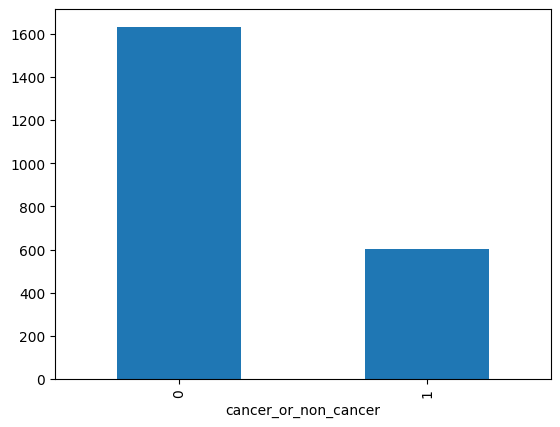

In [ ]:
#Plot Imbalance dataset
data[target_column].value_counts().plot(kind='bar')

**14. Handle Imbalancing Uning SMOTE**

In [ ]:
# Handle class imbalance using SMOTE
X = data.drop(columns=[target_column])
y = data[target_column]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())


Class distribution after SMOTE:
cancer_or_non_cancer
1    1633
0    1633
Name: count, dtype: int64


<Axes: xlabel='cancer_or_non_cancer'>

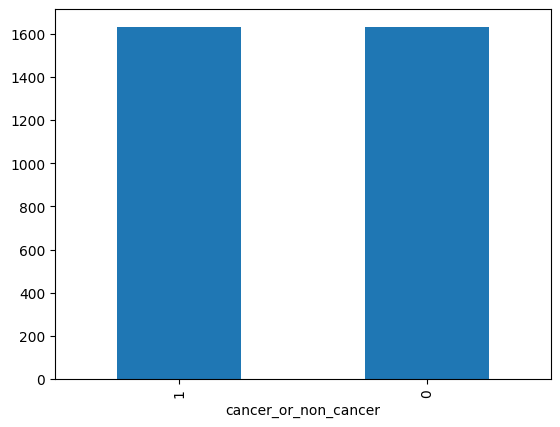

In [ ]:
 #Plot the balace dataset
 pd.Series(y_resampled).value_counts().plot(kind='bar')

**15. Correlation Analysis**

In [ ]:
print("\nCorrelation Analysis:")
correlation_matrix = data.corr()
correlation_with_target = correlation_matrix['cancer_or_non_cancer'].sort_values(ascending=False)
print(correlation_with_target)


Correlation Analysis:
cancer_or_non_cancer    1.000000
localization            0.068836
skin_color              0.017312
gender                  0.014332
age                     0.010503
sun_exposure            0.009561
alcohol_consumption     0.008785
tobacco_use            -0.005747
larger_size            -0.010883
Name: cancer_or_non_cancer, dtype: float64


**16. Visualization of Correlation values**

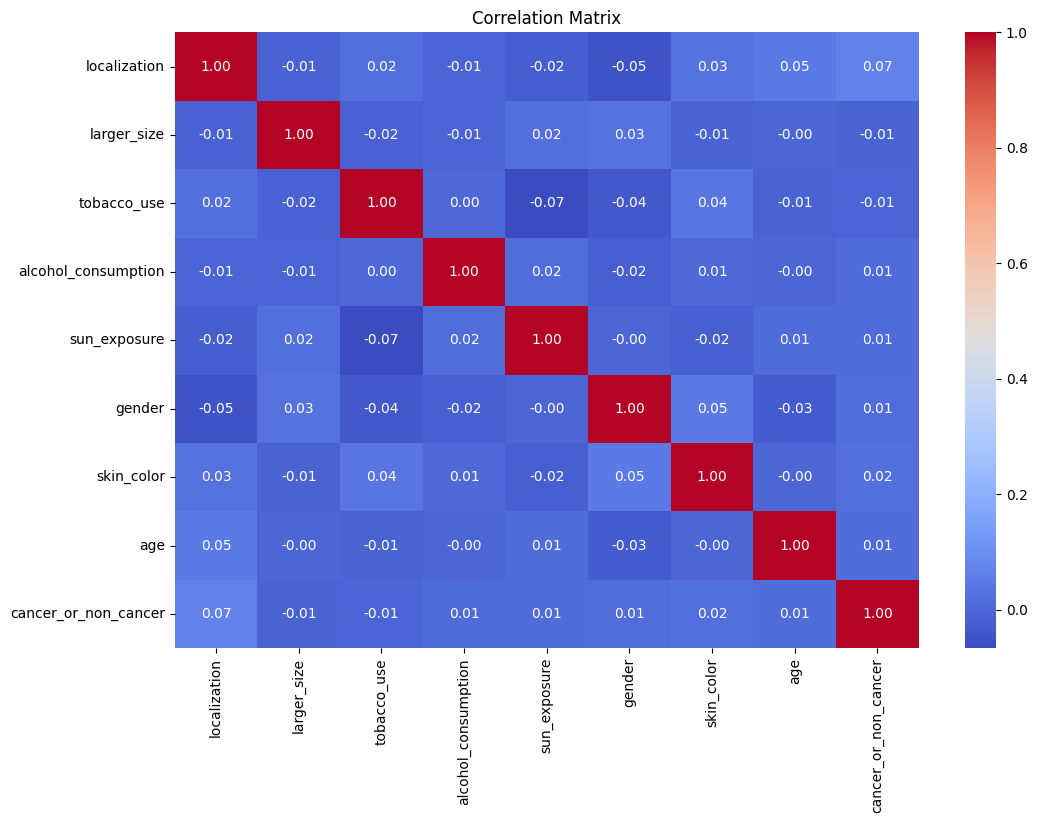

In [ ]:
# Visualize correlation with a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

**17. Features Selection**

**18. Dataset Splitting**

In [ ]:
# Print remaining features
print("\nRemaining features after dropping unnecessary columns:")
print(list(data.columns))


Remaining features after dropping unnecessary columns:
['localization', 'larger_size', 'tobacco_use', 'alcohol_consumption', 'sun_exposure', 'gender', 'skin_color', 'age', 'cancer_or_non_cancer']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 2286
Test set size: 980


In [ ]:
# Save feature names before scaling (to maintain correct order)
feature_names = X_train.columns.tolist()
print(feature_names)
with open('feature_names.pkl', 'wb') as file:
    pickle.dump(feature_names, file)

['localization', 'larger_size', 'tobacco_use', 'alcohol_consumption', 'sun_exposure', 'gender', 'skin_color', 'age']


**19. Feature Scaling**

In [ ]:
# Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler to use during predictions
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

print("Data preprocessing completed.")

Data preprocessing completed.


# **SVM Model Training**

In [ ]:
import pickle
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Load saved feature names
with open('feature_names.pkl', 'rb') as file:
    feature_names = pickle.load(file)

# Define parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}

# Initialize SVM model
svm_model = SVC(probability=True, random_state=42)

# Perform Grid Search for best hyperparameters
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search_svm.fit(X_train_scaled, y_train)

# Retrieve best parameters
best_params_svm = grid_search_svm.best_params_
print("\nBest Parameters for SVM:", best_params_svm)

# Train the best SVM model
svm_model_best = grid_search_svm.best_estimator_

# Evaluate on Test Data
y_pred_svm = svm_model_best.predict(X_test_scaled)
y_prob_svm = svm_model_best.predict_proba(X_test_scaled)[:, 1]

print("\n🔹 SVM Classification Report on Test Data:")
print(classification_report(y_test, y_pred_svm))
print(f"🔹 SVM ROC-AUC Score on Test Data: {roc_auc_score(y_test, y_prob_svm):.2f}")

# Evaluate on Training Data
y_train_pred_svm = svm_model_best.predict(X_train_scaled)
y_train_prob_svm = svm_model_best.predict_proba(X_train_scaled)[:, 1]

print("\n🔹 SVM Classification Report on Training Data:")
print(classification_report(y_train, y_train_pred_svm))
print(f"🔹 SVM ROC-AUC Score on Training Data: {roc_auc_score(y_train, y_train_prob_svm):.2f}")

# Save the trained SVM model
with open('svm_model_tuned.pkl', 'wb') as file:
    pickle.dump(svm_model_best, file)

print("\n✅ SVM model saved as 'svm_model_tuned.pkl'.")


Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best Parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

🔹 SVM Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.68      0.63      0.66       477
           1       0.67      0.72      0.70       503

    accuracy                           0.68       980
   macro avg       0.68      0.68      0.68       980
weighted avg       0.68      0.68      0.68       980

🔹 SVM ROC-AUC Score on Test Data: 0.74

🔹 SVM Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.83      0.76      0.80      1156
           1       0.77      0.84      0.81      1130

    accuracy                           0.80      2286
   macro avg       0.80      0.80      0.80      2286
weighted avg       0.80      0.80      0.80      2286

🔹 SVM ROC-AUC Score on Training Data: 0.88

✅ SVM model saved as 'svm_model_tuned.pkl

# **Neural Network Model Training**

In [ ]:
import pickle
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Load saved feature names
with open('feature_names.pkl', 'rb') as file:
    feature_names = pickle.load(file)

# Define hyperparameter grid for Neural Network
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [300, 500, 1000],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1]
}

# Initialize Neural Network model
nn_model = MLPClassifier(random_state=42, early_stopping=True, validation_fraction=0.1)

# Perform Randomized Search
random_search_nn = RandomizedSearchCV(nn_model, param_grid_nn, n_iter=20, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1, random_state=42)
random_search_nn.fit(X_train_scaled, y_train)

# Retrieve best parameters
best_params_nn = random_search_nn.best_params_
print("\nBest Parameters for Neural Network:", best_params_nn)

# Train the best Neural Network model
nn_model_best = random_search_nn.best_estimator_

# Evaluate on Test Data
y_pred_nn = nn_model_best.predict(X_test_scaled)
y_prob_nn = nn_model_best.predict_proba(X_test_scaled)[:, 1]

print("\n🔹 Neural Network Classification Report on Test Data:")
print(classification_report(y_test, y_pred_nn))
print(f"🔹 Neural Network ROC-AUC Score on Test Data: {roc_auc_score(y_test, y_prob_nn):.2f}")

# Evaluate on Training Data
y_train_pred_nn = nn_model_best.predict(X_train_scaled)
y_train_prob_nn = nn_model_best.predict_proba(X_train_scaled)[:, 1]

print("\n🔹 Neural Network Classification Report on Training Data:")
print(classification_report(y_train, y_train_pred_nn))
print(f"🔹 Neural Network ROC-AUC Score on Training Data: {roc_auc_score(y_train, y_train_prob_nn):.2f}")

# Save the trained Neural Network model
with open('nn_model.pkl', 'wb') as file:
    pickle.dump(nn_model_best, file)

print("\n✅ Neural Network model saved as 'nn_model.pkl'.")


Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters for Neural Network: {'solver': 'adam', 'max_iter': 300, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 50), 'alpha': 0.1, 'activation': 'relu'}

🔹 Neural Network Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.54      0.61      0.58       477
           1       0.58      0.51      0.54       503

    accuracy                           0.56       980
   macro avg       0.56      0.56      0.56       980
weighted avg       0.56      0.56      0.56       980

🔹 Neural Network ROC-AUC Score on Test Data: 0.60

🔹 Neural Network Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.61      0.67      0.64      1156
           1       0.62      0.57      0.60      1130

    accuracy                           0.62      2286
   macro avg       0.62      0.62      0.62      2286
weighte

In [ ]:
import pickle
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Load saved feature names
with open('feature_names.pkl', 'rb') as file:
    feature_names = pickle.load(file)

# Initialize XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# Evaluate on Test Data
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

print("\n🔹 XGBoost Classification Report on Test Data:")
print(classification_report(y_test, y_pred_xgb))
print(f"🔹 XGBoost ROC-AUC Score on Test Data: {roc_auc_score(y_test, y_prob_xgb):.2f}")

# Evaluate on Training Data
y_train_pred_xgb = xgb_model.predict(X_train_scaled)
y_train_prob_xgb = xgb_model.predict_proba(X_train_scaled)[:, 1]

print("\n🔹 XGBoost Classification Report on Training Data:")
print(classification_report(y_train, y_train_pred_xgb))
print(f"🔹 XGBoost ROC-AUC Score on Training Data: {roc_auc_score(y_train, y_train_prob_xgb):.2f}")

# Save the trained XGBoost model
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

print("\n✅ XGBoost model saved as 'xgb_model.pkl'.")



🔹 XGBoost Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       477
           1       0.76      0.74      0.75       503

    accuracy                           0.75       980
   macro avg       0.75      0.75      0.75       980
weighted avg       0.75      0.75      0.75       980

🔹 XGBoost ROC-AUC Score on Test Data: 0.84

🔹 XGBoost Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1156
           1       0.99      0.95      0.97      1130

    accuracy                           0.97      2286
   macro avg       0.97      0.97      0.97      2286
weighted avg       0.97      0.97      0.97      2286

🔹 XGBoost ROC-AUC Score on Training Data: 1.00

✅ XGBoost model saved as 'xgb_model.pkl'.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:14:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the trained Neural Network model
with open('nn_model.pkl', 'rb') as file:
    nn_model = pickle.load(file)

# Load the scaler and feature names from training
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

with open('feature_names.pkl', 'rb') as file:
    feature_names = pickle.load(file)  # Ensure correct feature order

# Define categorical and numerical features
categorical_features = ['localization', 'tobacco_use', 'alcohol_consumption', 'sun_exposure', 'gender', 'skin_color']
numerical_features = ['larger_size', 'age_group']

# Define LabelEncoders (Use mappings from training)
label_encoders = {
    'localization': LabelEncoder().fit(['Tongue', 'Lip', 'Floor of mouth', 'Buccal mucosa', 'Palate', 'Gingiva', 'Cheek', 'Gum', 'Buccal Mucosa']),
    'tobacco_use': LabelEncoder().fit(['Yes', 'Former', 'No', 'Not informed']),
    'alcohol_consumption': LabelEncoder().fit(['No', 'Former', 'Yes', 'Not informed']),
    'sun_exposure': LabelEncoder().fit(['No', 'Yes', 'Not informed']),
    'gender': LabelEncoder().fit(['M', 'F']),
    'skin_color': LabelEncoder().fit(['Black', 'White', 'Not informed', 'Brown', 'Asian', 'Hispanic']),
}

# Function to categorize age into groups
def categorize_age(age):
    if age < 40:
        return 0
    elif 40 <= age <= 60:
        return 1
    else:
        return 2

# Function to get user input
def get_user_input():
    """Take user input for all required features and return a dictionary."""
    features = ['localization', 'larger_size', 'tobacco_use', 'alcohol_consumption', 'sun_exposure', 'gender', 'skin_color', 'age']
    user_data = {}

    print("\nEnter values for the following features:")
    for feature in features:
        user_data[feature] = input(f"{feature}: ").strip()

    return user_data

# Take user input
user_data = get_user_input()

# Convert age input to numeric and categorize it
user_data['age'] = int(user_data['age'])
user_data['age_group'] = categorize_age(user_data['age'])

# Convert input data into a DataFrame
input_df = pd.DataFrame([user_data])

# Apply Label Encoding to categorical features (ensure consistency with training)
for feature in categorical_features:
    if user_data[feature] in label_encoders[feature].classes_:
        input_df[feature] = label_encoders[feature].transform([user_data[feature]])
    else:
        print(f"⚠️ Warning: Unseen category '{user_data[feature]}' for {feature}. Using 'Not informed' as default.")
        input_df[feature] = label_encoders[feature].transform(['Not informed'])

# Ensure numerical columns are correctly formatted
input_df[['larger_size', 'age_group']] = input_df[['larger_size', 'age_group']].astype(float)

# 🔹 **Ensure features are in the same order as training**
input_df = input_df.reindex(columns=feature_names, fill_value=0)  # Ensures correct feature order

# Standard Scaling (Use same scaler from training)
input_scaled = scaler.transform(input_df)

# Make prediction using Neural Network
nn_prob = nn_model.predict_proba(input_scaled)[:, 1]  # Probability of cancer
nn_pred = (nn_prob >= 0.5).astype(int)  # Convert probability to binary classification

# Display results
print("\n🔹 Predicted Probability of Oral Cancer:")
print(f"   {nn_prob[0]:.4f}")

print("\n🔹 Final Prediction:")
print("   🛑 Cancer Detected" if nn_pred[0] == 1 else "   ✅ No Cancer Detected")



Enter values for the following features:
localization: Gingiva
larger_size: 1
tobacco_use: Yes
alcohol_consumption: Yes
sun_exposure: No
gender: M
skin_color: Asian
age: 50

🔹 Predicted Probability of Oral Cancer:
   0.0000

🔹 Final Prediction:
   ✅ No Cancer Detected


# **XGBoost Model Training**

# **Accuracy comparison of models**

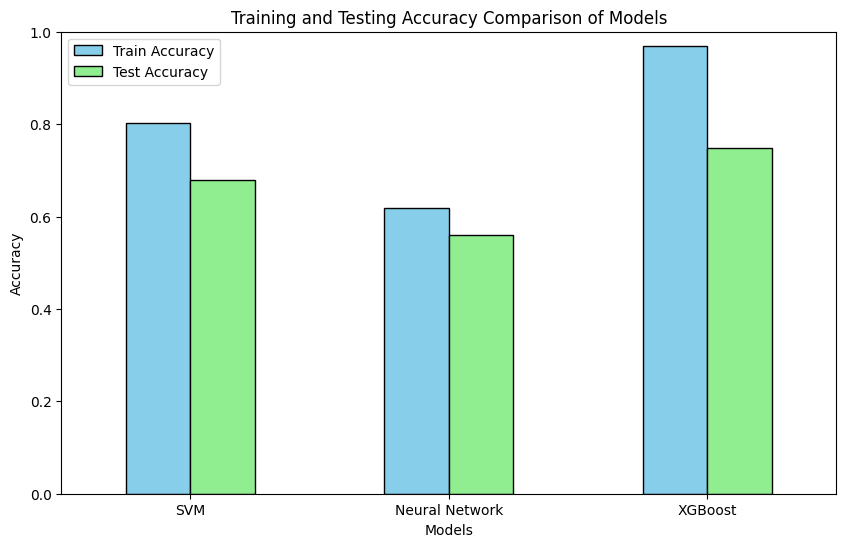

            Model  Train Accuracy  Test Accuracy
0             SVM        0.801837       0.678571
1  Neural Network        0.617673       0.560204
2         XGBoost        0.968504       0.747959


In [ ]:
# Create a dictionary to store the results
results = {
    'Model': ['SVM', 'Neural Network', 'XGBoost'],
    'Train Accuracy': [
        accuracy_score(y_train, svm_model_best.predict(X_train_scaled)),
        accuracy_score(y_train, nn_model_best.predict(X_train_scaled)),
        accuracy_score(y_train, xgb_model.predict(X_train_scaled))
    ],
    'Test Accuracy': [
        accuracy_score(y_test, svm_model_best.predict(X_test_scaled)),
        accuracy_score(y_test, nn_model_best.predict(X_test_scaled)),
        accuracy_score(y_test, xgb_model.predict(X_test_scaled))
    ]
}

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Plot the comparison
results_df.set_index('Model').plot(kind='bar', figsize=(10, 6), color=['skyblue', 'lightgreen'], edgecolor='black')
plt.title('Training and Testing Accuracy Comparison of Models')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # Set the y-axis limit from 0 to 1 for accuracy
plt.show()

# Print the results DataFrame
print(results_df)


  0%|          | 0/980 [00:00<?, ?it/s]

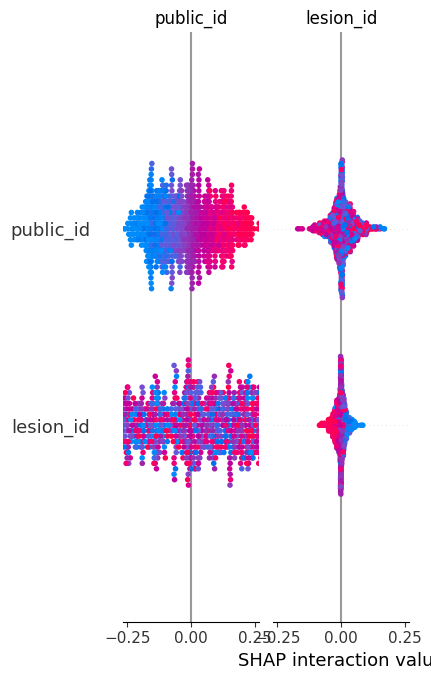

DimensionError: Length of features is not equal to the length of shap_values!

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Use k-means to summarize the background data
background_data = shap.kmeans(X_train_scaled, 100)
# Initialize SHAP explainer with the k-means summarized background data
explainer = shap.KernelExplainer(nn_model_best.predict_proba, background_data)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test_scaled)

# Visualize feature importance (summary plot)
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)

# Visualize SHAP values for a single prediction (force plot)
# Use the correct index for sample data
sample_index = 0  # Choose the sample index (adjust as needed)

# Ensure X_test_scaled is a pandas DataFrame
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][sample_index, :],
    X_test_scaled_df.iloc[sample_index, :],
    matplotlib=True
)

# Feature importance bar plot
plt.figure(figsize=(5, 5))
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, plot_type="bar")


In [ ]:
# Install the LIME package if not already installed
!pip install lime

import lime
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Initialize the LIME explainer for the neural network model
explainer = LimeTabularExplainer(
    training_data=X_train_scaled.values,
    feature_names=X.columns,
    class_names=['Non-Cancer', 'Cancer'],
    mode='classification'
)

# Select a random sample from the test set for explanation
sample_index = np.random.randint(0, len(X_test_scaled))
sample_data = X_test_scaled.iloc[sample_index]

# Convert the sample data to a NumPy array
sample_data_array = sample_data.values.reshape(1, -1)

# Generate LIME explanation for the selected sample
explanation = explainer.explain_instance(
    data_row=sample_data_array[0],
    predict_fn=nn_model_best.predict_proba
)

# Visualize the explanation in the notebook
explanation.show_in_notebook(show_table=True)

# Save the explanation as an HTML file (optional)
explanation.save_to_file("lime_explanation_neural_network.html")

print("LIME explanation saved as 'lime_explanation_neural_network.html'.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c5ca80e44af9a491103caa7edb80d9119583f6bbb2fd8618842e3904d24cf4b9
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
#svm old
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],        # Regularization parameter
    'kernel': ['linear', 'rbf'], # Kernel types
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf'
}

# Perform GridSearchCV for SVM
svm_model = SVC(probability=True, random_state=42)
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters from grid search
best_params = grid_search.best_params_
print("\nBest Parameters for SVM:", best_params)

# Train the SVM model with the best parameters
svm_model_best = grid_search.best_estimator_

# Evaluate the tuned SVM Model on Test Data
y_pred = svm_model_best.predict(X_test_scaled)
y_prob = svm_model_best.predict_proba(X_test_scaled)[:, 1]

# Print classification report and ROC-AUC score for the test data
print("\nTuned SVM Classification Report on Test Data:")
print(classification_report(y_test, y_pred))
print(f"Tuned SVM ROC-AUC Score on Test Data: {roc_auc_score(y_test, y_prob):.2f}")

# Evaluate the tuned SVM Model on Training Data (Optional for Overfitting Check)
y_train_pred = svm_model_best.predict(X_train_scaled)
y_train_prob = svm_model_best.predict_proba(X_train_scaled)[:, 1]

# Print classification report and ROC-AUC score for the training data
print("\nTuned SVM Classification Report on Training Data:")
print(classification_report(y_train, y_train_pred))
print(f"Tuned SVM ROC-AUC Score on Training Data: {roc_auc_score(y_train, y_train_prob):.2f}")

# Save the trained tuned SVM model
with open('svm_model_tuned.pkl', 'wb') as file:
    pickle.dump(svm_model_best, file)

print("\nTuned SVM model saved as 'svm_model_tuned.pkl'.")

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best Parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Tuned SVM Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.73      0.68      0.71       477
           1       0.72      0.77      0.74       503

    accuracy                           0.72       980
   macro avg       0.72      0.72      0.72       980
weighted avg       0.72      0.72      0.72       980

Tuned SVM ROC-AUC Score on Test Data: 0.79

Tuned SVM Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      1156
           1       0.89      0.92      0.90      1130

    accuracy                           0.90      2286
   macro avg       0.90      0.90      0.90      2286
weighted avg       0.90      0.90      0.90      2286

Tuned SVM ROC-AUC Score on Training Data: 0.96

Tuned SVM model saved as 